In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import json
from utils.transformations import min_max_normalization, inverse_min_max_normalization, transform_to_sparse, inverse_transform_to_sparse
import warnings
warnings.filterwarnings('ignore', category=UserWarning) #Ignore sklearn "RF fitted with FeatureNames"

train_dataset = pd.read_csv("../data/adult.csv")
dataset_name = 'adult'
instance_to_explain_index = 2

with open('../data/adult_constraints.json', 'r') as f:
    constr = json.load(f)

train_dataset = train_dataset[constr['features_order_nonsplit']]
train_dataset.columns

Index(['hours.per.week', 'age', 'capital.loss', 'education.num',
       'capital.gain', 'workclass', 'marital.status', 'occupation', 'race',
       'sex', 'native.country', 'income'],
      dtype='object')

In [2]:
query_instance = train_dataset.drop(columns="income")[instance_to_explain_index:instance_to_explain_index+1]

all_counterfactuals = pd.DataFrame(columns=train_dataset.columns.tolist() + ['explainer'])

In [3]:
query_instance

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country
2,40,66,4356,10,0,?,Widowed,?,Black,Female,United-States


In [4]:
from dice import DiceModel

dice_model = DiceModel(
    train_dataset=train_dataset,
    continuous_features=constr['continuous_features_nonsplit'],
    categorical_features=constr['categorical_features_nonsplit'],
    target=constr['target_feature'],
    model_path='../models/adult_RF.pkl',
    backend='sklearn',
    func='ohe-min-max',
)

dice_counterfactuals_df = dice_model.generate_counterfactuals(
    query_instance=query_instance,
    total_CFs=40,
    desired_class='opposite',
    features_to_vary=constr['actionable_features'],
    permitted_range=constr['feature_ranges'],
)

dice_counterfactuals_df['explainer'] = 'dice'
all_counterfactuals = pd.concat([all_counterfactuals, dice_counterfactuals_df], ignore_index=True)

100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


In [5]:
all_counterfactuals.head(5)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,7.0,77.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,1,dice
1,40.0,47.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,1,dice
2,59.0,38.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,1,dice
3,40.0,55.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,1,dice
4,40.0,17.0,4356.0,14.0,0.0,?,Widowed,?,Black,Female,United-States,1,dice


In [6]:

# Transform dataset to sparse
train_dataset_sparse = transform_to_sparse(
    _df=train_dataset.drop(columns="income"),
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Min-max normalization
train_dataset_sparse_normalized = min_max_normalization(
    _df=train_dataset_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

query_instance_sparse_normalized = train_dataset_sparse_normalized[instance_to_explain_index:instance_to_explain_index+1]

In [7]:
from alibi_impl import AlibiWachter

model = AlibiWachter('../models/adult_RF.pkl', 'sklearn', query_instance_sparse_normalized.shape)
explanation = model.generate_counterfactuals(query_instance_sparse_normalized)


c:\ProgramData\Anaconda3\envs\cf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
wachter_counterfactuals = []
for key, lst in explanation['data']['all'].items():
    if lst:
        for cf in lst:
            wachter_counterfactuals.append(cf['X'])

wachter_counterfactuals = np.array(wachter_counterfactuals).reshape(-1, query_instance_sparse_normalized.shape[1])

wachter_counterfactuals_df = pd.DataFrame(wachter_counterfactuals, columns=constr['features_order_after_split'])

# Inverse min-max normalization
wachter_counterfactuals_df = inverse_min_max_normalization(
    _df=wachter_counterfactuals_df,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Inverse transform to sparse
wachter_counterfactuals_df = inverse_transform_to_sparse(
    sparse_df=wachter_counterfactuals_df,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

wachter_counterfactuals_df['explainer'] = 'wachter'

# Reduce number of Wachter counterfactuals because they are almost the same
sampled_wachter_cfs = wachter_counterfactuals_df.sample(40)

all_counterfactuals = pd.concat([all_counterfactuals, sampled_wachter_cfs], ignore_index=True)

wachter_counterfactuals_df.head(5)

C:\Users\ignacy\AppData\Local\Temp\ipykernel_23152\1253476118.py:2: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  for key, lst in explanation['data']['all'].items():
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')


,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,explainer
0,26,17,4356,5,4538,?,Widowed,?,Black,Female,United-States,wachter
1,18,17,4356,4,0,?,Widowed,?,Black,Female,United-States,wachter
2,11,17,4356,3,0,?,Widowed,?,Black,Female,United-States,wachter
3,5,17,4356,2,0,?,Widowed,?,Black,Female,United-States,wachter
4,1,17,4356,1,0,?,Widowed,?,Black,Female,United-States,wachter


In [9]:
wachter_counterfactuals_df.shape

(750, 12)

CFPROTO

In [43]:
from alibi.explainers import CounterfactualProto

import pickle
with open('../models/adult_RF.pkl', 'rb') as f:
    model = pickle.load(f)
predict_fnct = lambda x: model.predict(x)


In [44]:
cat_vars_ord = {}
for i, cat in enumerate(constr['categorical_features_nonsplit']):
    start_index = np.argwhere(cat == train_dataset.columns.to_numpy())[0][0]
    unique = len(np.unique(train_dataset[cat]))
    cat_vars_ord[start_index] = unique
print(cat_vars_ord)

{5: 9, 6: 7, 7: 15, 8: 5, 9: 2, 10: 42}


In [45]:


# cf = CounterfactualProto(predict_fnct, query_instance_sparse_normalized.shape, use_kdtree=True, theta=10., feature_range=(0.0, 1.0))
# cf.fit(train_dataset_sparse_normalized, trustscore_kwargs=None)

In [66]:
cfProto = CounterfactualProto(predict_fnct,
                         query_instance_sparse_normalized.shape,
                         cat_vars=cat_vars_ord,
                         ohe=True,  # OHE flag
                         max_iterations=500,
                         beta=0.01,
                         feature_range=(0.0, 1.0),
                         use_kdtree=True,
                         theta= 10.,
                         c_init=1.0,
                         c_steps=5
                        )

In [71]:
cfProto.fit(train_dataset_sparse_normalized.to_numpy(), d_type='abdm', trustscore_kwargs=None)

c:\ProgramData\Anaconda3\envs\cf\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
No encoder specified. Using k-d trees to represent class prototypes.


CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'kappa': 0.0,
              'beta': 0.01,
              'gamma': 0.0,
              'theta': 10.0,
              'cat_vars': {5: 9, 6: 7, 7: 15, 8: 5, 9: 2, 10: 42},
              'ohe': True,
              'use_kdtree': True,
              'learning_rate_init': 0.01,
              'max_iterations': 500,
              'c_init': 1.0,
              'c_steps': 5,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'feature_range': (0.0, 1.0),
              'shape': (1, 85),
              'is_model': False,
              'is_ae': False,
              'is_enc': False,
              'enc_or_kdtree': True,
              'is_cat': True,
              'trustscore_kwargs': None,
              'd_type': 'abdm',
              'w'

In [72]:
query_instance_sparse_normalized.to_numpy().shape

(1, 85)

In [73]:
explanation = cfProto.explain(query_instance_sparse_normalized.to_numpy())

ValueError: Cannot feed value of shape (1, 77) for Tensor assign_orig_3:0, which has shape (1, 11)

ECE

In [30]:
# from cfec_ece import CfecEceModel 
# import tensorflow as tf

# model = tf.keras.models.load_model('../models/adult_NN/')

# model_predictions = model.predict(train_dataset_sparse_normalized)
# model_predictions = np.argmax(model_predictions, axis=1)

# cfec_model = CfecEceModel(
#     train_data=train_dataset_sparse_normalized,
#     model_predictions=model_predictions,
#     )

# cfec_counterfactuals = cfec_model.generate_counterfactuals(query_instance=query_instance)

TypeError: CfecEceModel.__init__() missing 1 required positional argument: 'constraints_dictionary'

VISUALIZATION

In [11]:
from visualization_helpers import get_scores
from visualization_helpers import remove_duplicates

all_counterfactuals = remove_duplicates(all_counterfactuals)
print('Counterfactuals: ', all_counterfactuals.shape)

# Transform counterfactuals to sparse
counterfactuals_sparse = transform_to_sparse(
    _df=all_counterfactuals,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Normalize counterfactuals
counterfactuals_sparse_normalized = min_max_normalization(
    _df=counterfactuals_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)


# Transform query instance to sparse
query_instance_sparse = transform_to_sparse(
    _df=query_instance,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Normalize query instance sparse
query_instance_sparse_normalized = min_max_normalization(
    _df=query_instance_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Mask non actionable features
mask_indices = [1 if any([act in x for act in constr['actionable_features']]) else 0 for x in constr['features_order_after_split']]

Counterfactuals:  (61, 13)


In [12]:
from visualization_helpers import filter_non_valid
from visualization_helpers import filter_non_actionable
import pickle

# SKLEARN
with open('../models/adult_RF.pkl', 'rb') as f:
    model = pickle.load(f)

# TENSORFLOW
# model = tf.keras.models.load_model('../models/adult_NN/')

predict_fn = lambda x: model.predict(x)

valid_counterfactuals_sparse_normalized = filter_non_valid(predict_fn, query_instance_sparse_normalized, counterfactuals_sparse_normalized)
valid_counterfactuals_sparse_normalized.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
           dtype='int64')

In [13]:
valid_counterfactuals = all_counterfactuals.iloc[valid_counterfactuals_sparse_normalized.index]
valid_counterfactuals.reset_index(drop=True, inplace=True)
valid_counterfactuals = filter_non_actionable(valid_counterfactuals, query_instance, constr['non_actionable_features'])
valid_counterfactuals.reset_index(drop=True, inplace=True)
valid_counterfactuals.shape

(61, 3)
(1, 3)


(61, 13)

In [14]:
# add income column
valid_counterfactuals['income'] = np.argmax(predict_fn(valid_counterfactuals_sparse_normalized.to_numpy()[0:1]))
valid_counterfactuals.head(5)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,7.0,77.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,0,dice
1,40.0,47.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,0,dice
2,59.0,38.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,0,dice
3,40.0,55.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,0,dice
4,40.0,17.0,4356.0,14.0,0.0,?,Widowed,?,Black,Female,United-States,0,dice


In [15]:
scores_df = get_scores(valid_counterfactuals_sparse_normalized.to_numpy(), query_instance_sparse_normalized, train_dataset_sparse_normalized, train_dataset['income'], mask_indices)

In [25]:
scores_df['explainer'] = valid_counterfactuals['explainer']
scores_df.head(10)

,cf,proximity,features_changed,feasibility,actionability,preference_dcg,discriminative_power,dispreference_dcg,non_discriminative_power,explainer
0,"[0.061224489795918366, 0.821917808219178, 1.0,...",0.487420,2,1.007235,True,0.150685,0.000000,10.703951,1.000000,dice
1,"[0.3979591836734694, 0.410958904109589, 1.0, 0...",0.260274,1,1.005195,True,0.260274,0.033333,10.594362,0.966667,dice
2,"[0.5918367346938775, 0.2876712328767123, 1.0, ...",0.577439,2,1.064739,True,0.383562,0.000000,10.471074,1.000000,dice
3,"[0.3979591836734694, 0.5205479452054794, 1.0, ...",0.150685,1,1.000188,True,0.150685,0.033333,10.703951,0.966667,dice
4,"[0.3979591836734694, 0.0, 1.0, 0.8666666666666...",0.937900,2,1.220848,True,0.804566,0.000000,10.050069,1.000000,dice
5,"[0.061224489795918366, 0.6712328767123288, 17....",16.575486,2,265.922961,True,10.245511,0.000000,0.609124,1.000000,dice
6,"[0.3979591836734694, 0.1506849315068493, 1.0, ...",0.520548,1,1.071713,True,0.520548,0.000000,10.334088,1.000000,dice
7,"[0.04081632653061224, 0.6712328767123288, 1.0,...",0.557143,2,1.023215,True,0.100000,0.000000,10.754636,1.000000,dice
8,"[0.3979591836734694, 0.3698630136986301, 1.0, ...",0.301370,1,1.009136,True,0.301370,0.033333,10.553266,0.966667,dice
9,"[0.05102040816326531, 0.6712328767123288, 1.0,...",1.085686,2,1.554484,True,0.318161,0.000000,10.536474,1.000000,dice


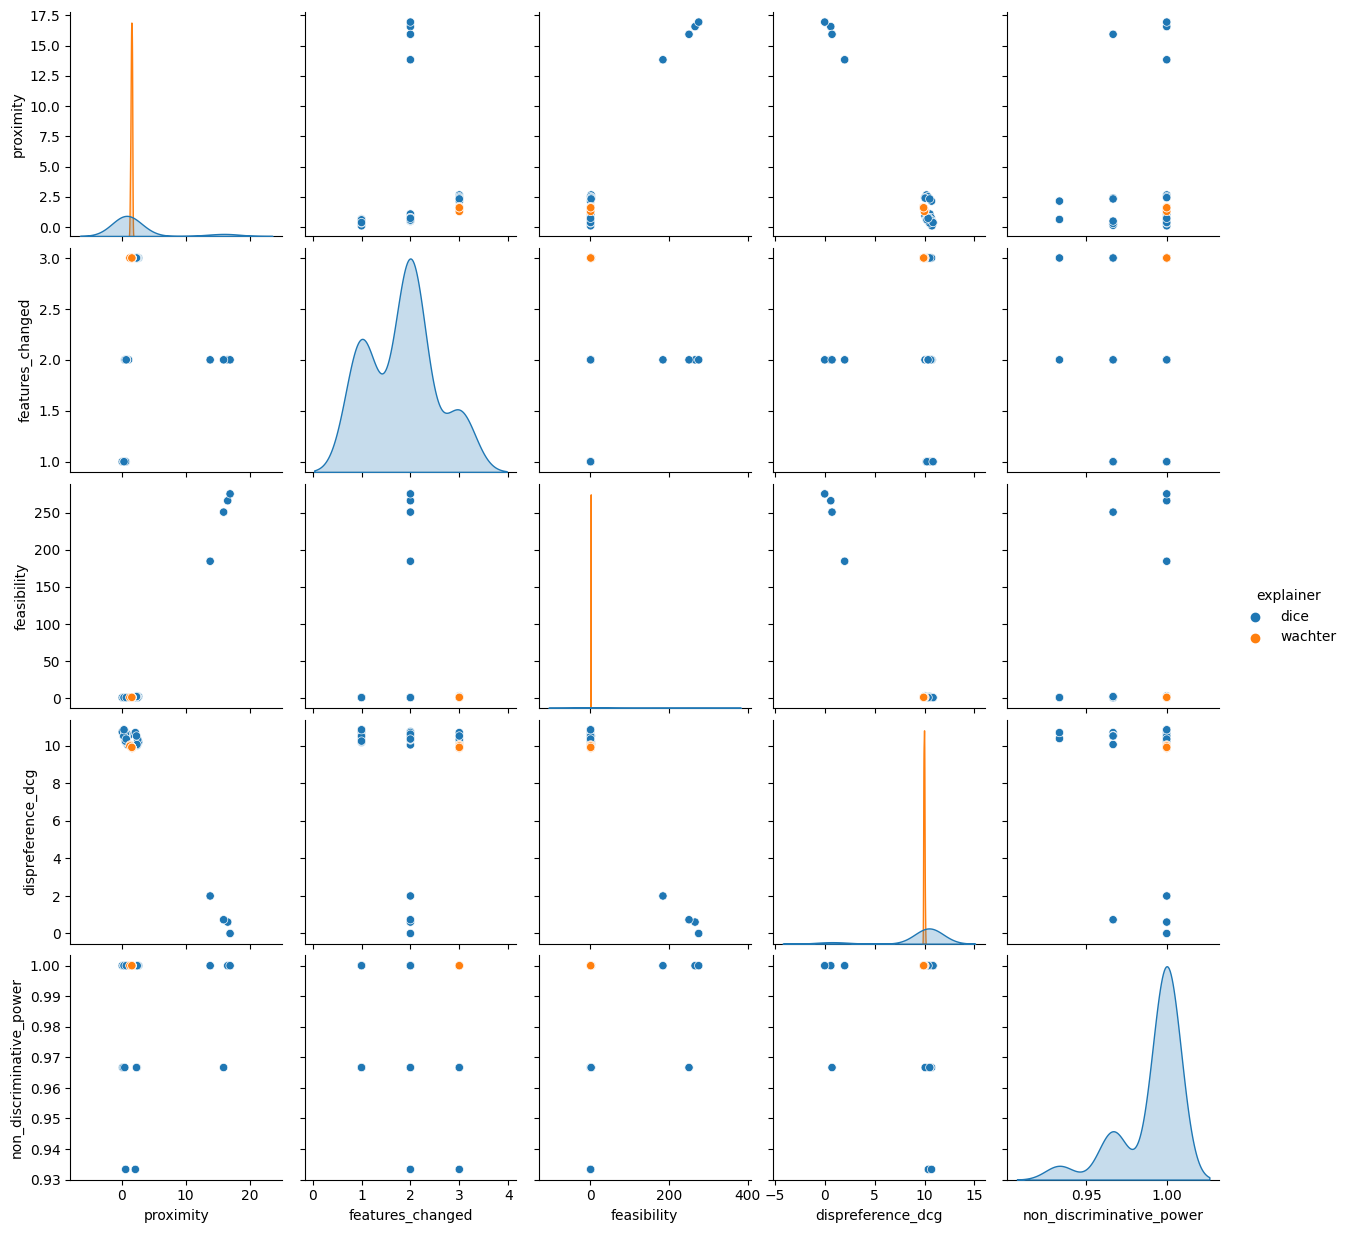

In [17]:
import seaborn as sns

# We want to plot only subset of columns 
scores_to_plot = scores_df.drop(['cf', 'actionability', 'preference_dcg', 'discriminative_power'], axis=1)

# Pairplot
sns.pairplot(scores_to_plot, hue="explainer", diag_kind='kde')

In [26]:
if 'sklearn' in str(type(model)):
    explained_model = 'RF'
else:
    explained_model = 'NN'

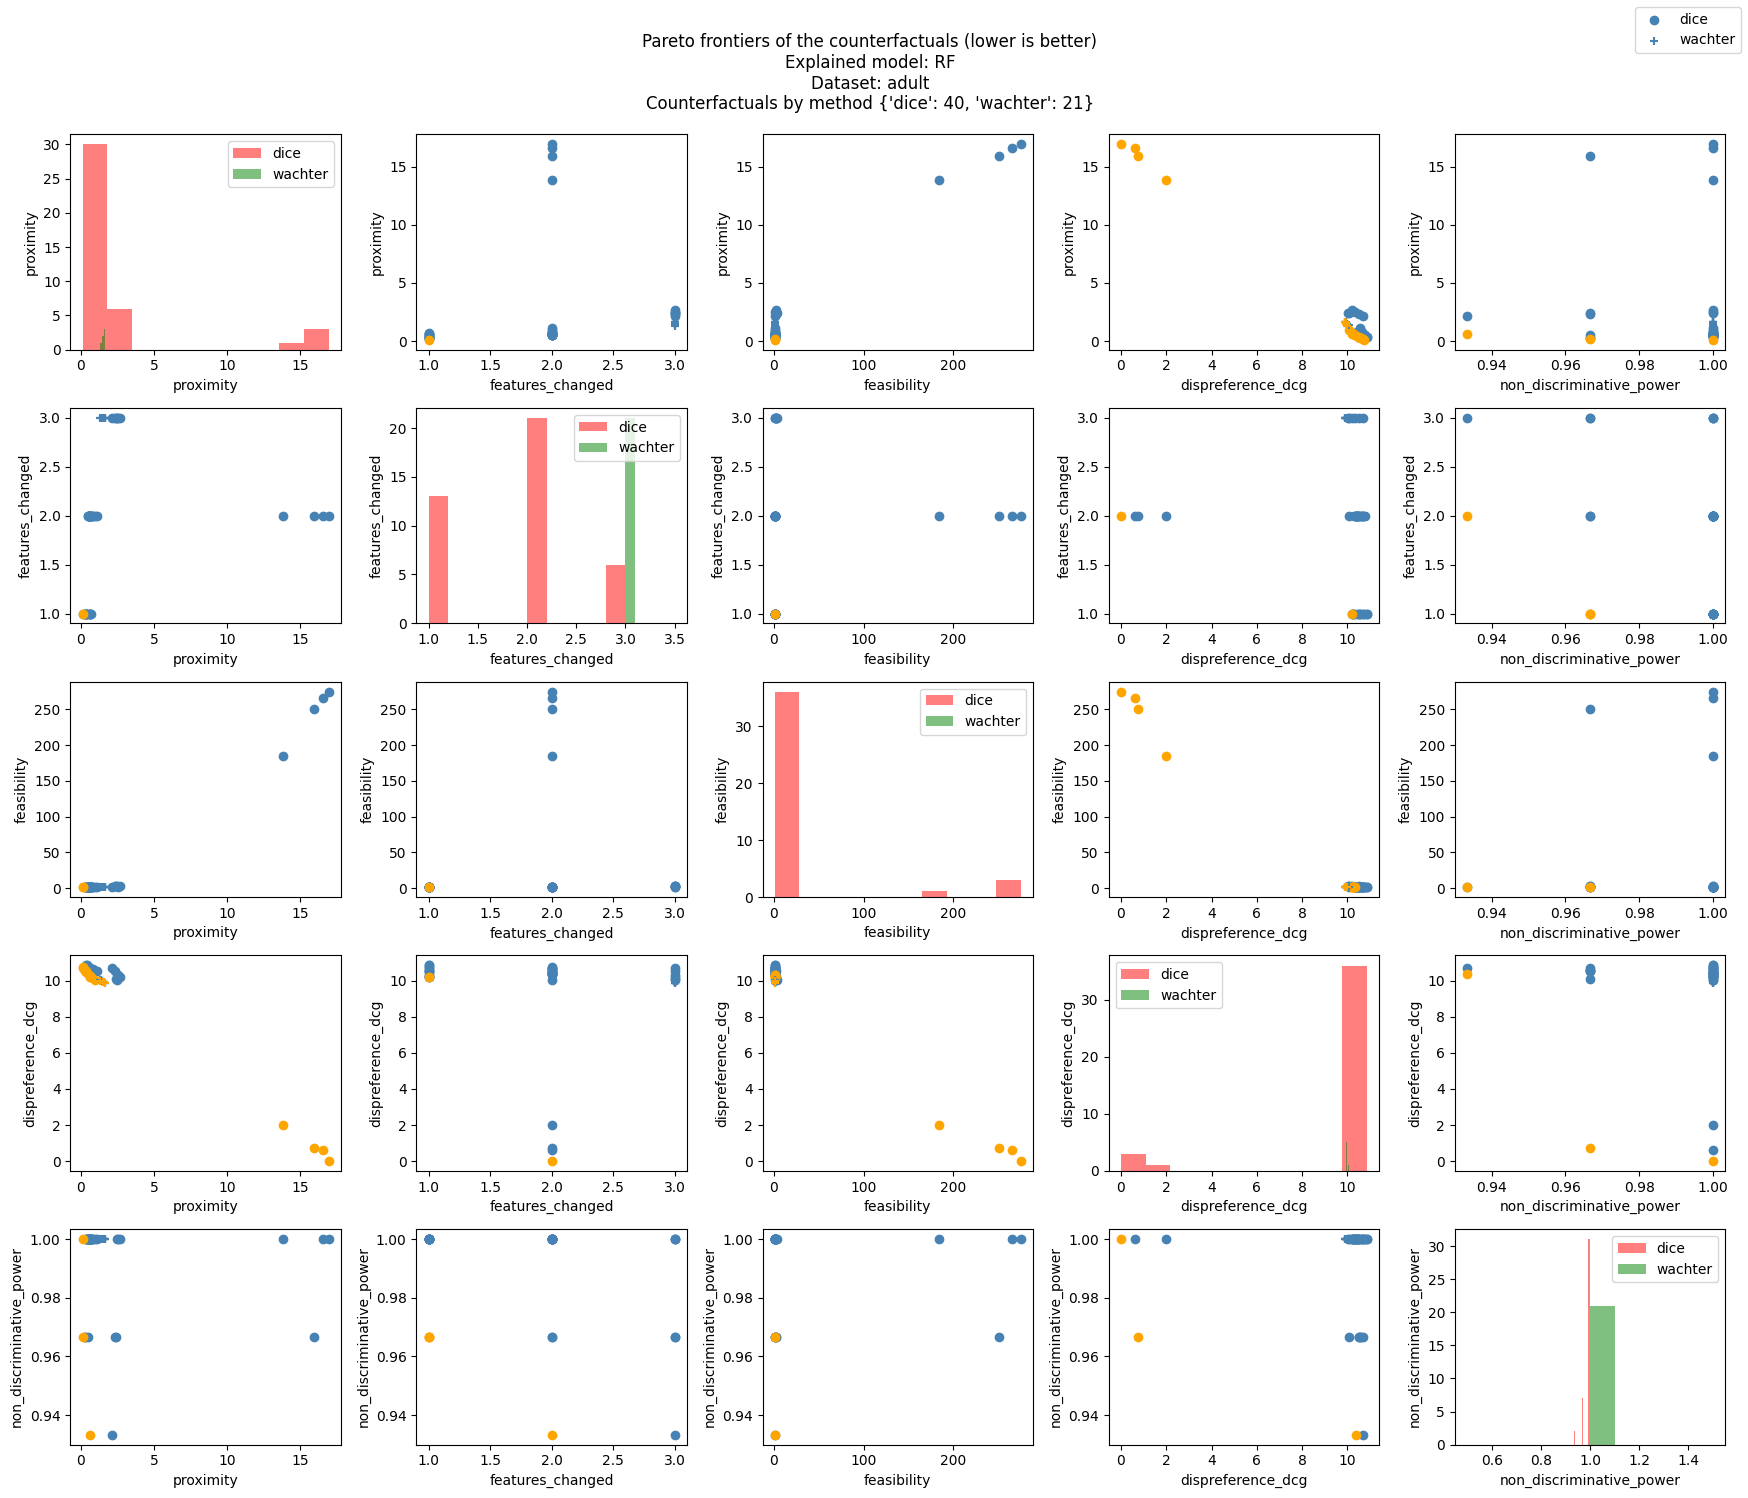

In [27]:
import matplotlib.pyplot as plt
from visualization_helpers import get_pareto_frontier_mask


metrics_to_plot = ['proximity', 'features_changed', 'feasibility', 'dispreference_dcg', 'non_discriminative_power']
n = len(metrics_to_plot)

fig, ax = plt.subplots(n, n, figsize=(3.5*n, 3*n))

colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
markers = ['o', '+', 'x', 'v', '^', 's', 't']
labels = []

ax = ax.flatten()

for i, other_metric in enumerate(metrics_to_plot):
    for j, metric in enumerate(metrics_to_plot):

        all_x = scores_df[metric].to_numpy()
        all_y = scores_df[other_metric].to_numpy()
        to_check = np.array([all_x, all_y], dtype=np.float64).T
        all_pareto = get_pareto_frontier_mask(to_check)

        for k, explainer in enumerate(scores_df['explainer'].unique()):

            mask = scores_df['explainer'] == explainer
            pareto = all_pareto[mask]

            x = scores_df[mask][metric].to_numpy()
            y = scores_df[mask][other_metric].to_numpy()

            if i == j:
                ax[i*n+j].hist(x, color=colors[k], label=explainer, alpha=0.5)
                ax[i*n+j].legend()
            else:
                ax[i*n+j].scatter(x[~pareto], y[~pareto], color='steelblue', marker=markers[k], label=explainer)
                ax[i*n+j].scatter(x[pareto], y[pareto], color='orange', marker=markers[k])

        
        ax[i*n+j].set_xlabel(metric)
        ax[i*n+j].set_ylabel(other_metric)
    # plt.title('Proximity vs Dispreference DCG \n(Pareto front in orange). \nLower is better.')

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

counts = scores_df['explainer'].value_counts()

plt.suptitle(f'Pareto frontiers of the counterfactuals (lower is better)\nExplained model: {explained_model}\nDataset: {dataset_name}\nCounterfactuals by method {counts.to_dict()}\n')
plt.tight_layout()
plt.savefig(f'../images/{dataset_name}/{explained_model}/{dataset_name}_pairplot_with_frontiers_{instance_to_explain_index}.png')
plt.show()